# Imports

In [1]:
import math
import time
import random
import matplotlib.pyplot as plt
import os
import warnings
import dataclasses as dc
import typing as tp
warnings.filterwarnings("ignore") # W0901 12:56:55.922000 133054240231424 torch/fx/experimental/symbolic_shapes.py:4449] [0/1] xindex is not in var_ranges, defaulting to unknown range.

import torch
from torch import Tensor, nn, _assert
from torch.nn import functional as F
import torch.utils.data
from torchvision import datasets, transforms

from src import FashionMNIST_config as config
from src import DiffusionUtils
from src import Transfussion, CosineDecayWithWarmup
from src import LLaMA

In [2]:
config()

FashionMNIST_config(var_range=(0.0001, 0.02), num_timesteps=400, patch_size=2, H=28, W=28, in_channels=1, out_channels=1, N=196, d_model=512, num_heads=8, num_layers=8, num_classes=10, dropout_rate=0.0, text_maxlen=6, maxlen=398, batch_size=64, num_steps=50000, decay_steps=15000, warmup_steps=100, max_lr=0.0003, min_lr=0.0, no_decay=True, beta1=0.9, beta2=0.99, clipnorm=1.0, weight_decay=0.0, patience=10, num_grad_accumalation_steps=1, return_best_train_states=True, log_interval=1, eval_freq=600, balancing_coeff=5.0, BOI=tensor(10), IGNORE_TOKEN=tensor(11), EOI=tensor(12), EOS=tensor(13), lm_output_units=14, ckpt_dir='checkpoints/fashionmnist')

# Data Loader

In [3]:
class DataLoader:
    def __init__(self, train:bool):
        transform = transforms.Compose([
            transforms.ToTensor(), # (H, W, C)/(H, W) -> (C, H, W) AND [0, 255] -> [0.0, 1.0]
            transforms.Normalize(mean=(0.5,), std=(0.5,), inplace=True) # [0.0, 1.0] -> [-1.0, 1.0]
        ])
        if train:
            self.ds = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
        else:
            self.ds = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
        self.class_dict = self.ds.class_to_idx
        
    def iter_batches(self, batch_size):
        while True:
            self.dataset = torch.utils.data.DataLoader(
                dataset=self.ds,
                batch_size=batch_size,
                shuffle=True,
                pin_memory=True,
                drop_last=True
            )
            for X_batch, y_batch in self.dataset:
                yield X_batch.to(config.device), y_batch.to(config.device)

# Trainer

In [4]:
class MNISTTransfusionTrainer:
    def __init__(self, model:Transfussion, config:config):
        self.model = model
        self.autocast = torch.autocast(
            device_type=config.device.type,
            dtype={"bfloat16": torch.bfloat16,
                    "float32" : torch.float32}[config.dtype_type]
        )
        self.patch_ops = model.patch_ops
        self.diff_utils = DiffusionUtils(linear_schedule=False, config=config) # for smaller image prefer cosine schedule, for larger image prefer linear schedule

        self.BOI = config.BOI.to(config.device)
        self.IGNORETOK = config.IGNORE_TOKEN.to(config.device)
        self.EOI = config.EOI.to(config.device)
        self.EOS = config.EOS.to(config.device)

        self.balancing_coeff = config.balancing_coeff
        self.config = config

    def make_instances(self, X1:Tensor, y1:Tensor, X2:Tensor, y2:Tensor):
        B = X1.size(0)
        # text to image: Example
        # input:    1   <BOI>     imgp1, imgp2, imgp3, imgp4 <EOI>  2    <BOI>     imgp1, imgp2, imgp3, imgp4 <EOI>
        # target: <BOI> IGNORETOK imgp1, imgp2, imgp3, imgp4   2   <BOI> IGNORETOK imgp1, imgp2, imgp3, imgp4 <EOS>
        inputs:list[tp.Any] = []; targets:list[Tensor] = []
        modality_strings:list[str] = []

        BOI = self.BOI.repeat(B).view(B, 1)
        EOI = self.EOI.repeat(B).view(B, 1)
        IGNORETOK = self.IGNORETOK.repeat(B).view(B, 1)
        EOS = self.EOS.repeat(B).view(B, 1)

        # text
        t1 = torch.cat([
            y1,         # (B, T=1)
            BOI,        # (B, T=1)
            IGNORETOK,  # (B, T=1)
        ], dim=1)
        inputs.append(t1[:, :-1].clone()); targets.append(t1[:, 1:].clone())
        modality_strings.append("text")

        # image
        timesteps1 = torch.randint(0, self.config.num_timesteps, (B,), device=self.config.device)
        noised_X1, noise_in_X1 = self.diff_utils.noisy_it(X1, timesteps1)
        inputs.append(
            (self.patch_ops.patchify(noised_X1), timesteps1)
        )
        targets.append(
            self.patch_ops.patchify(noise_in_X1)
        )
        modality_strings.append("image")
        
        # text
        t2 = torch.cat([
            EOI,        # (B, T=1)
            y2,         # (B, T=1)
            BOI,        # (B, T=1)
            IGNORETOK,  # (B, T=1)
        ], dim=1)
        inputs.append(t2[:, :-1].clone()); targets.append(t2[:, 1:].clone())
        modality_strings.append("text")
        
        # image
        timesteps2 = torch.randint(0, self.config.num_timesteps, (B,), device=self.config.device)
        noised_X2, noise_in_X2 = self.diff_utils.noisy_it(X2, timesteps2)
        inputs.append(
            (self.patch_ops.patchify(noised_X2), timesteps2)
        )
        targets.append(
            self.patch_ops.patchify(noise_in_X2)
        )
        modality_strings.append("image")

        # text
        inputs.append(EOI); targets.append(EOS)
        modality_strings.append("text")
        _assert(len(inputs) == len(targets) == len(modality_strings), "Length mismatch {} = {} = {} ???".format(len(inputs), len(targets), len(modality_strings)))
        return inputs, targets, modality_strings
    
    def compute_loss(self, outputs:list[Tensor], targets:list[Tensor], modalities:list[str]):
        # ["text",        "image",        "text",         "image",       "text"  ]
        # [(B, T, V), (B, N, (P**2)*C),  (B, T, V),   (B, N, (P**2)*C), (B, T, V)] # outputs
        # [(B, T)   , (B, N, (P**2)*C),  (B, T)   ,   (B, N, (P**2)*C), (B, T)   ] # targets

        ce = mse = 0
        for out, tar, mod in zip(outputs, targets, modalities):
            if mod == "text":
                ce += F.cross_entropy(
                    out.movedim(-1, -2), # (B, vocab_size, T) <= (B, T, vocab_size)
                    tar,                 # (B, T)
                    ignore_index=self.IGNORETOK.item()
                )
            elif mod == "image":
                mse += F.mse_loss(out, tar)
            else:
                raise ValueError(f"Unknown modality {mod}")
        return ce + self.balancing_coeff * mse, (ce.detach().cpu().item(), mse.detach().cpu().item())
    
    def __call__(self, iterator:tp.Iterator[tuple[Tensor, Tensor]]):
        (X1, y1), (X2, y2) = next(iterator), next(iterator)
        
        inputs, targets, modality_strings = self.make_instances(
            X1, y1.unsqueeze(1), # (B, C, H, W), (B, T=1)
            X2, y2.unsqueeze(1)  # (B, C, H, W), (B, T=1)
        )
        
        with self.autocast:
            modality_tok_emb, modality_strings = self.model(inputs, modality_strings)
            loss, (ce, mse) = self.compute_loss(modality_tok_emb, targets, modality_strings)
        return loss, ce, mse

In [5]:
model = Transfussion(
    model=LLaMA(config),
    config=config
).to(config.device)
# model.compile() # sssssppppeeeeeddddd # comment this line while debugging

optimizer = model.configure_optimizers(
    weight_decay=config.weight_decay,
    learning_rate=config.max_lr,
    betas=(config.beta1, config.beta2),
    device_type=config.device.type
)

get_lr = CosineDecayWithWarmup(
    warmup_steps=config.warmup_steps,
    max_learning_rate=config.max_lr,
    decay_steps=config.decay_steps,
    min_learning_rate=config.min_lr
) if not config.no_decay else lambda _: config.max_lr

train_iterator = iter(DataLoader(train=True).iter_batches(config.batch_size))
val_ds = DataLoader(train=False)
val_iterator = iter(val_ds.iter_batches(batch_size=1))

transfusion_trainer = MNISTTransfusionTrainer(model, config)

# test the trainer
# l, c, m = transfusion_trainer(train_iterator)
# print(l, c, m)
print(val_ds.class_dict)

{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}


```python
model = Transfussion(
    model=LLaMA(config(maxlen=10)),
    config=config(maxlen=10)
).to(config.device)
model._compute_mask([(4, 4)]).cpu().numpy()


array([[[[  0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
         [  0.,   0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
         [  0.,   0.,   0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
         [  0.,   0.,   0.,   0., -inf, -inf, -inf, -inf, -inf, -inf],
         [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., -inf, -inf],
         [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., -inf, -inf],
         [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., -inf, -inf],
         [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., -inf, -inf],
         [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., -inf],
         [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]]]],
      dtype=float32)
```

In [6]:
@torch.no_grad()
def evaluate():
    model.eval()
    txt1:Tensor = next(val_iterator)[1]
    txt1 = txt1.view(1, 1) # (B=1, T=1)

    modality_tokens, modality_strings = model.generate(
        modality_tokens=[txt1],
        modality_strings=["text"],
        diff_utils=transfusion_trainer.diff_utils,
        autocast=transfusion_trainer.autocast,
    )

    lst:list[tuple[str, Tensor]] = []
    for mod, tok in zip(modality_strings, modality_tokens):
        if mod == "text":
            lst.append((mod, tok))
        elif mod == "image":
            lst.append((
                mod,
                model.patch_ops.unpatchify(tok[0]).squeeze(0).cpu().detach()
            ))
        else:
            raise ValueError(f"Unknown modality: {mod}")
    model.train()
    return lst

In [7]:
def remove_special_tokens(tokens:Tensor):
    high = min([config.BOI.item(), config.EOI.item(), config.IGNORE_TOKEN.item(), config.EOS.item()])
    return tokens[tokens < high]

In [8]:
def plot_eval(modality_tokens:list[tuple[str, Tensor]]):
    fig, axes = plt.subplots(2, 1, figsize=(5, 10))
    
    txt1 = remove_special_tokens(modality_tokens[0][1].squeeze().detach().cpu()).tolist()
    img1 = modality_tokens[1][1].squeeze().detach().cpu().numpy()
    txt2 = remove_special_tokens(modality_tokens[2][1].squeeze().detach().cpu()).tolist()
    img2 = modality_tokens[3][1].squeeze().detach().cpu().numpy()

    # Plot the first image
    print(val_ds.class_dict)
    axes[0].imshow(img1, cmap='gray')
    axes[0].set_title(txt1)

    # Plot the second image
    axes[1].imshow(img2, cmap='gray')
    axes[1].set_title(txt2)

    # Add spacing between plots
    plt.tight_layout()

    # Display the plot
    plt.show()

In [9]:
print("Number of parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6, "M")

Number of parameters: 25.190234 M


In [ ]:
os.makedirs(config.ckpt_dir, exist_ok=True)

def train():
    t0 = time.time()
    losses = []
    for step in range(0, config.num_steps):
        lr = get_lr(step)
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr

        if (step % config.eval_freq == 0 and step > 0) or step == config.num_steps-1:
            try:
                eval_list = evaluate()
                plot_eval(eval_list)
            except Exception as e:
                print("Error")
                print(e)

            checkpoint = {
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "step": step,
                "train_config": dc.asdict(config()),
                "losses": losses
            }
            
            print(f"Saving checkpoint to {config.ckpt_dir} ...", end=" ==> ")
            torch.save(checkpoint, os.path.join(config.ckpt_dir, f"ckpt{step}.pt"))
            print("Done.")
            
        
        optimizer.zero_grad(set_to_none=True)
        for _ in range(config.num_grad_accumalation_steps):
            loss, ce, mse = transfusion_trainer(train_iterator)
            loss.backward()
        if config.clipnorm is not None:
            norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=config.clipnorm, error_if_nonfinite=True)
        optimizer.step()

        t1 = time.time()
        dt = t1-t0
        t0 = t1
        lossf = loss.detach().cpu().item() * config.num_grad_accumalation_steps
        if step % config.log_interval == 0:
            print(
                f"| Step: {step} || Loss: {lossf:.4f} || LmLoss: {ce:.3f} || DiffLoss: {mse:.3f} |"
                f"| LR: {lr:e} || dt: {dt*1000:.2f}ms |", end="")
            print(f"| Norm: {norm:.4f} |" if config.clipnorm is not None else "")
        losses.append(lossf)
    return losses

losses = train() # clear logging, very large

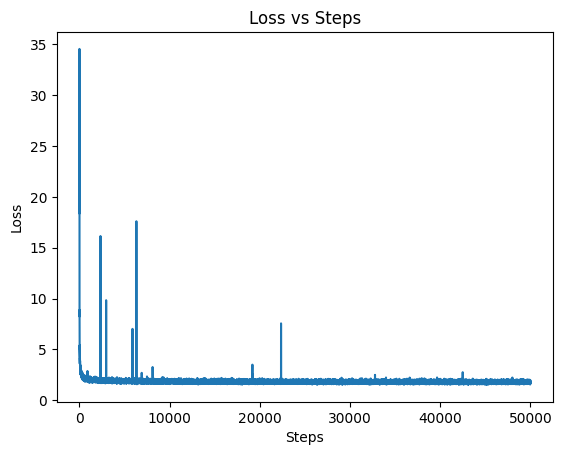

In [11]:
plt.plot(losses)
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Loss vs Steps")
plt.show()

100%|██████████| 399/399 [00:01<00:00, 261.12it/s]


{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}


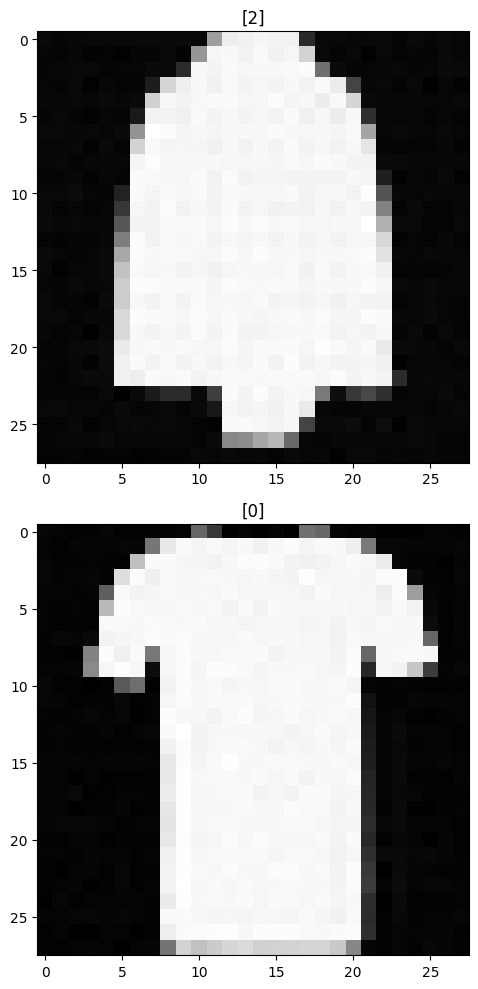

In [12]:
eval_list = evaluate()
plot_eval(eval_list)

100%|██████████| 399/399 [00:01<00:00, 264.33it/s]


{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}


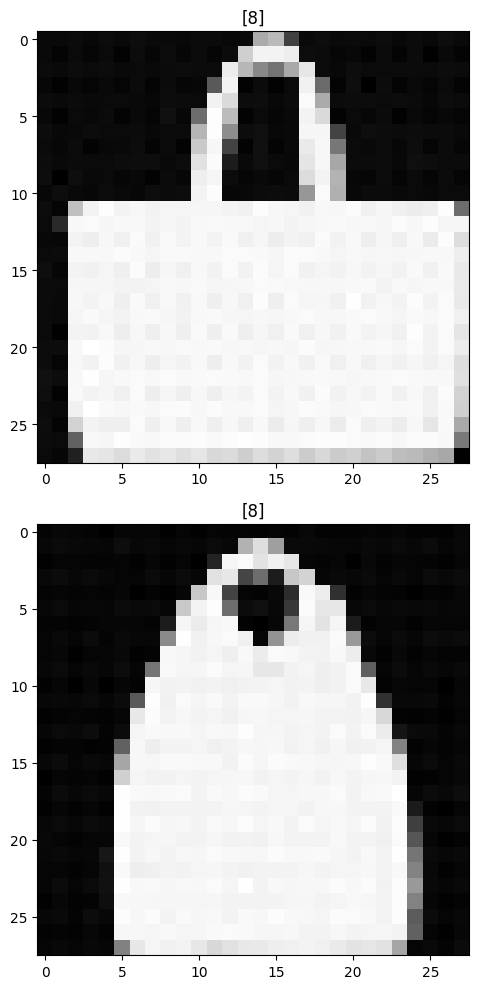

In [13]:
eval_list = evaluate()
plot_eval(eval_list)

100%|██████████| 399/399 [00:01<00:00, 257.54it/s]


{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}


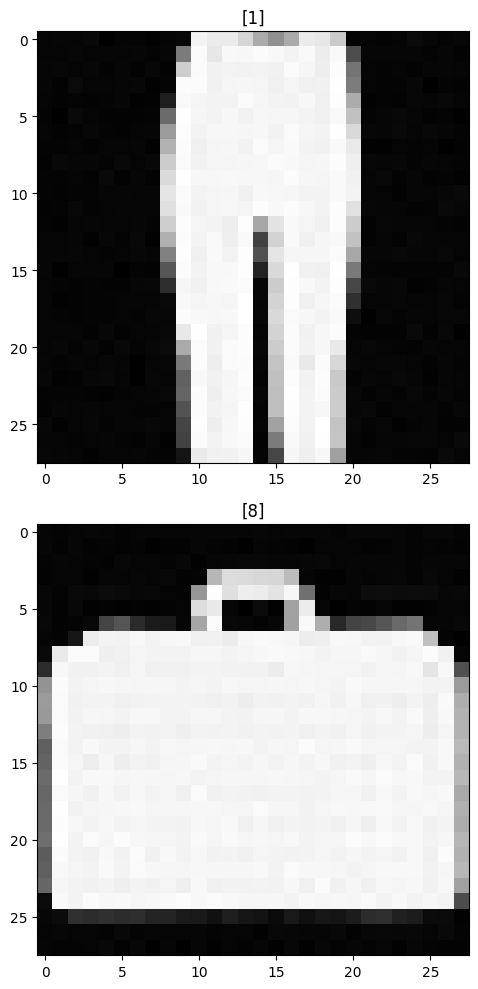

In [14]:
eval_list = evaluate()
plot_eval(eval_list)

100%|██████████| 399/399 [00:01<00:00, 259.31it/s]

{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}


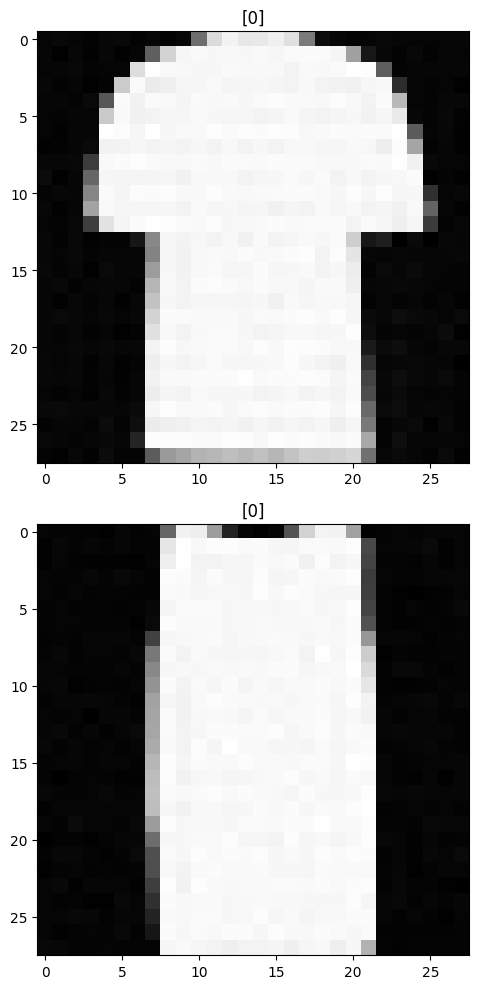

In [15]:
eval_list = evaluate()
plot_eval(eval_list)

100%|██████████| 399/399 [00:01<00:00, 256.01it/s]


{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}


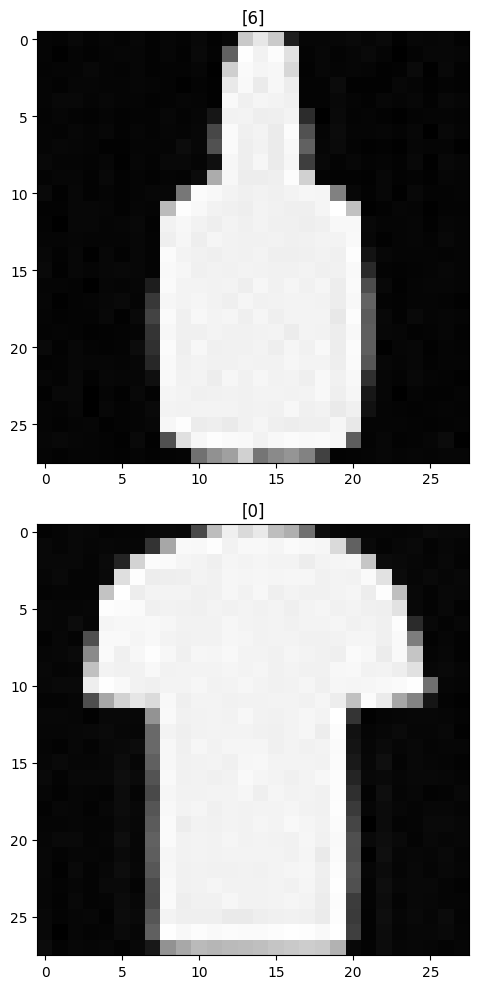

In [16]:
eval_list = evaluate()
plot_eval(eval_list)

100%|██████████| 399/399 [00:01<00:00, 260.07it/s]


{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}


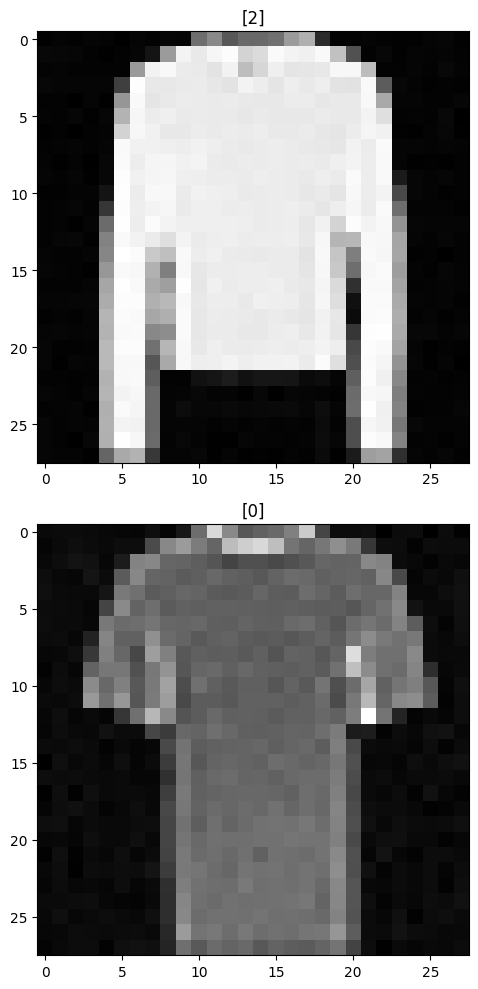

In [17]:
eval_list = evaluate()
plot_eval(eval_list)

100%|██████████| 399/399 [00:01<00:00, 266.77it/s]


{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}


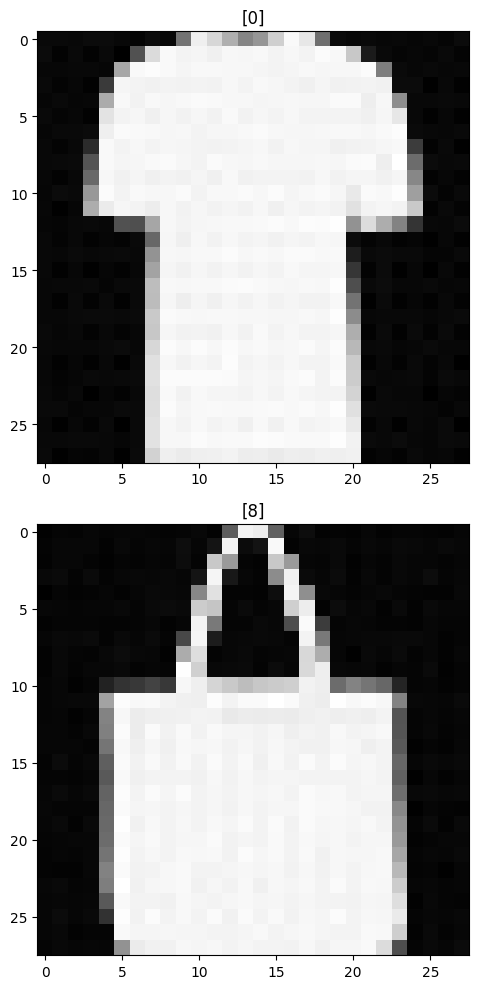

In [18]:
eval_list = evaluate()
plot_eval(eval_list)

100%|██████████| 399/399 [00:01<00:00, 259.11it/s]

{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}


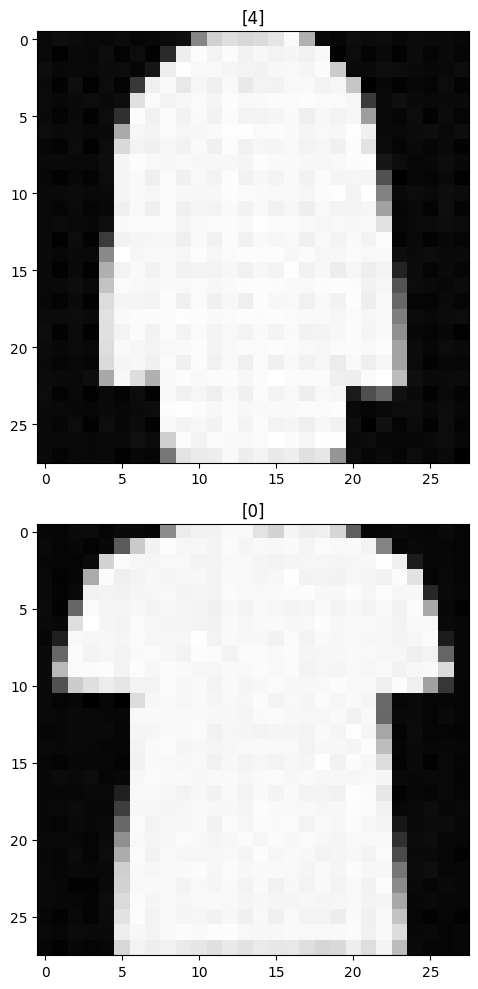

In [19]:
eval_list = evaluate()
plot_eval(eval_list)

100%|██████████| 399/399 [00:01<00:00, 266.35it/s]


{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}


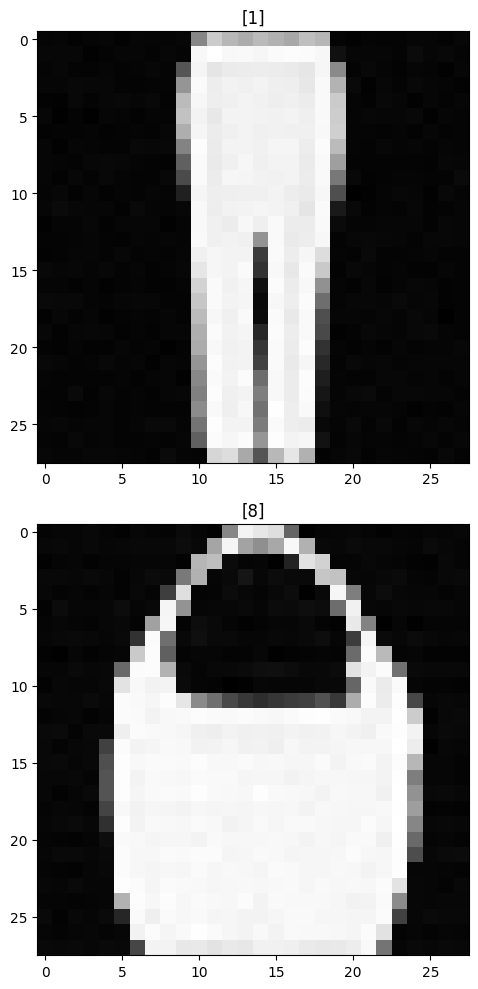

In [20]:
eval_list = evaluate()
plot_eval(eval_list)

100%|██████████| 399/399 [00:01<00:00, 263.85it/s]


{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}


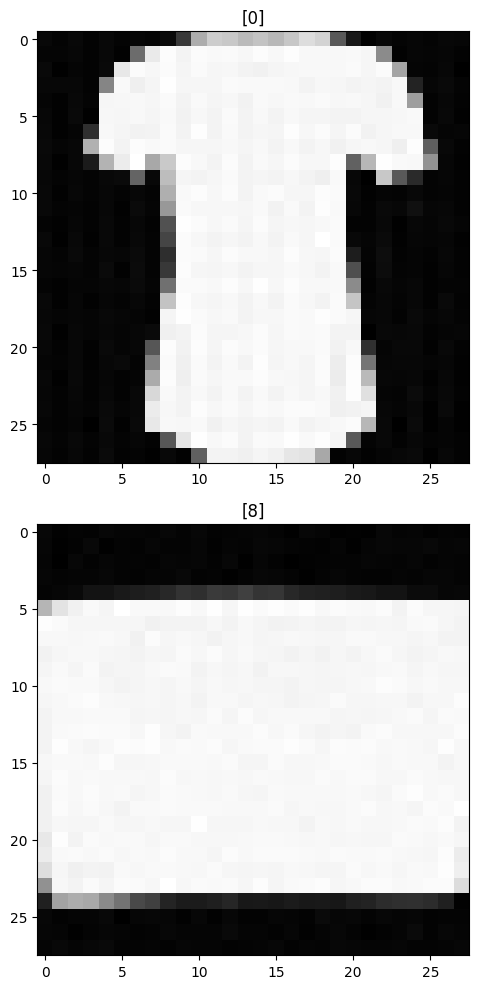

In [21]:
eval_list = evaluate()
plot_eval(eval_list)

100%|██████████| 399/399 [00:01<00:00, 264.97it/s]


{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}


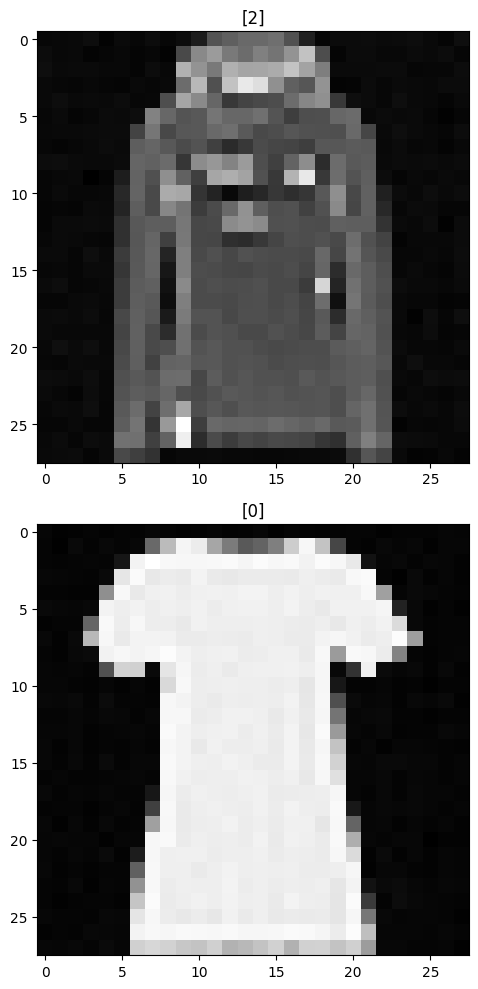

In [22]:
eval_list = evaluate()
plot_eval(eval_list)

100%|██████████| 399/399 [00:01<00:00, 264.41it/s]


{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}


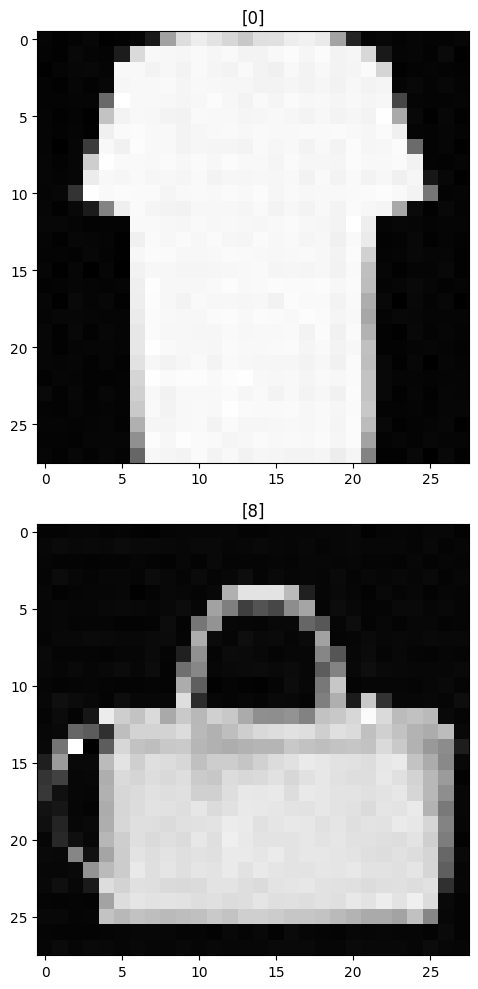

In [23]:
eval_list = evaluate()
plot_eval(eval_list)

100%|██████████| 399/399 [00:01<00:00, 265.35it/s]


{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}


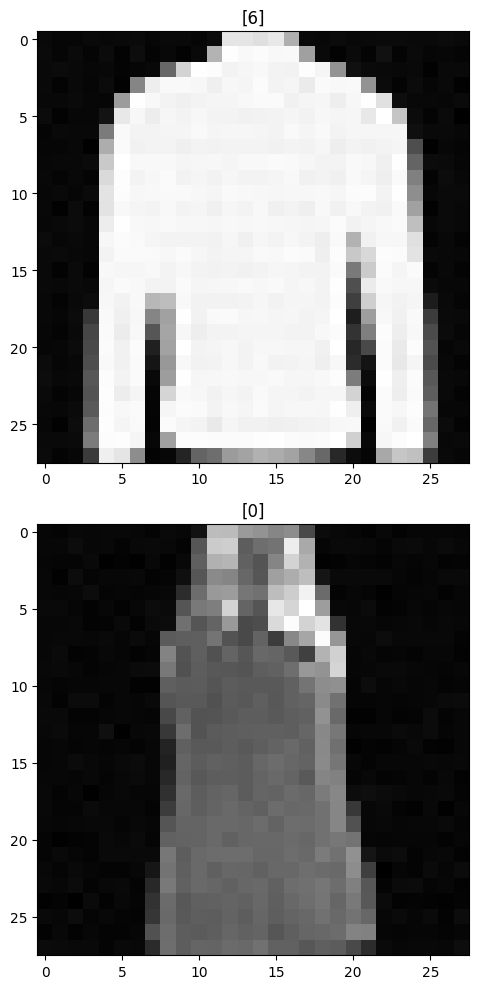

In [24]:
eval_list = evaluate()
plot_eval(eval_list)

100%|██████████| 399/399 [00:01<00:00, 264.72it/s]


{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}


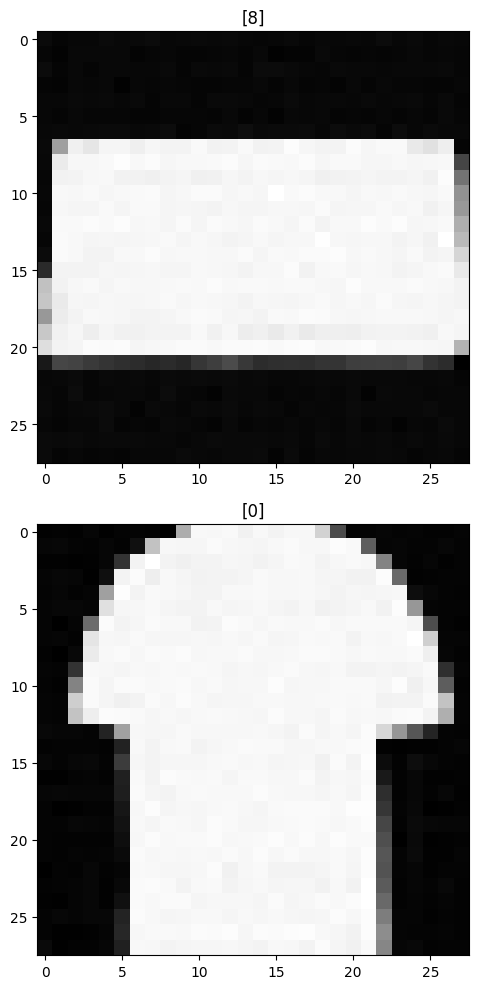

In [25]:
eval_list = evaluate()
plot_eval(eval_list)

100%|██████████| 399/399 [00:01<00:00, 265.54it/s]


{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}


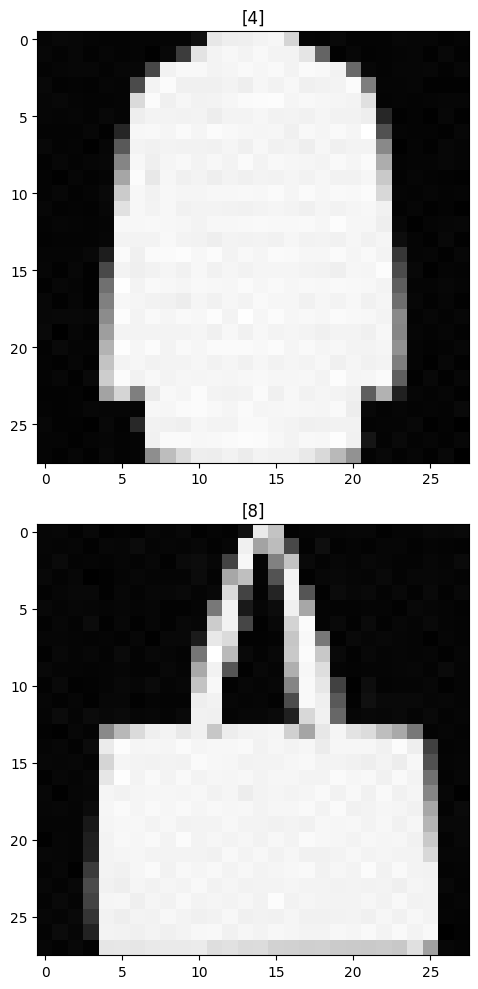

In [26]:
eval_list = evaluate()
plot_eval(eval_list)

100%|██████████| 399/399 [00:01<00:00, 259.09it/s]

{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}


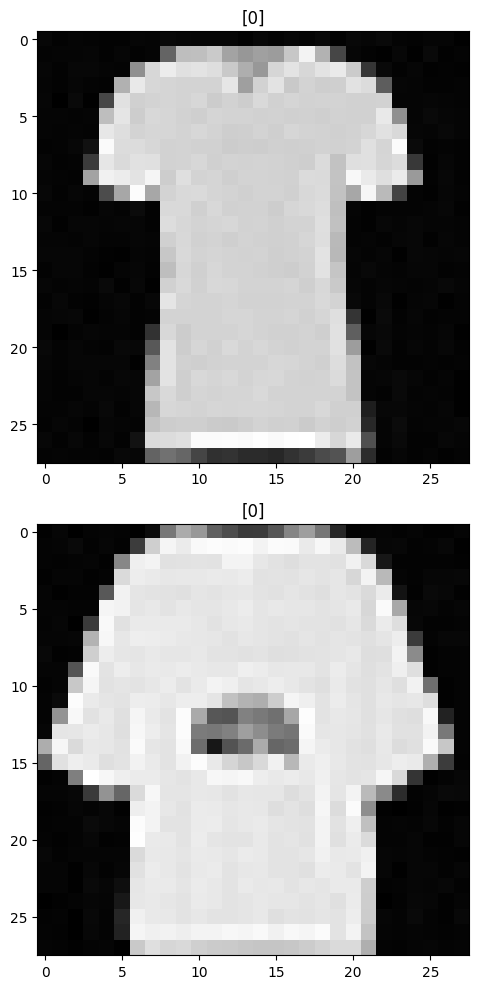

In [27]:
eval_list = evaluate()
plot_eval(eval_list)

100%|██████████| 399/399 [00:01<00:00, 259.10it/s]

{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}


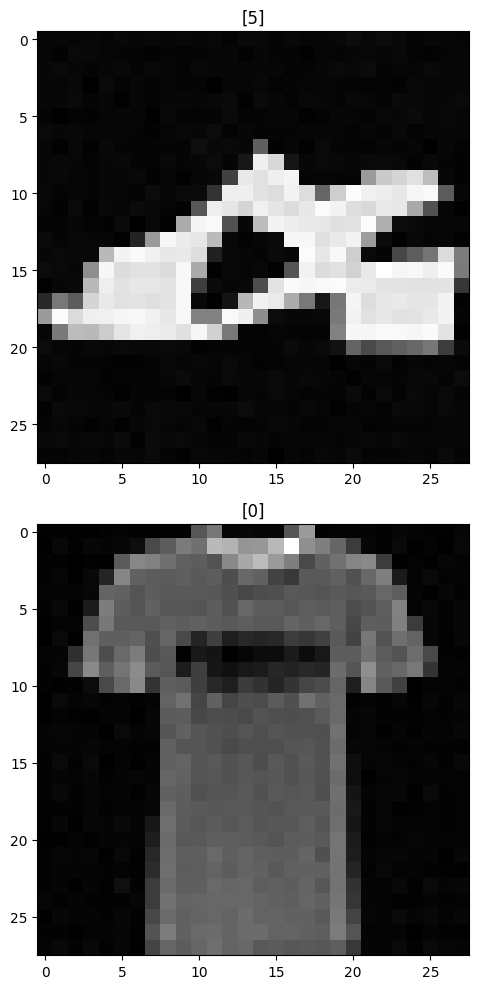

In [28]:
eval_list = evaluate()
plot_eval(eval_list)

100%|██████████| 399/399 [00:01<00:00, 263.35it/s]


{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}


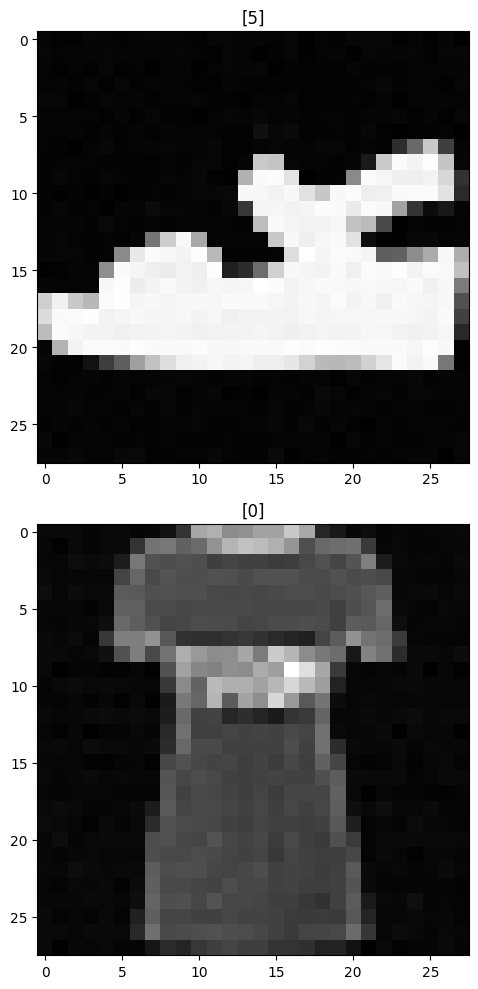

In [29]:
eval_list = evaluate()
plot_eval(eval_list)